In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline 


In [2]:
## read in data
ret_df_raw= pd.read_excel( io= 'Data/cipc data.xlsx', sheetname= 'Data_Input', index_col=0)
ret_df_raw.describe()

,US NCREIF: FUND INDEX OPEN-END DIVERSIFIED CORE RETURNS NADJ,US Private Equity,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM,USGOVT10Y,Cash
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,0.018311,0.034503,0.018989,0.035495,0.024647,0.027670,0.028452,0.017290,0.032061,0.017342,0.008155
std,0.029578,0.047497,0.047757,0.070263,0.064625,0.076253,0.099660,0.091792,0.128686,0.040278,0.006670
min,-0.136900,-0.159500,-0.333429,-0.214401,-0.215870,-0.219432,-0.261180,-0.211290,-0.275584,-0.060971,0.000000
25%,0.012925,0.011300,0.007742,0.004679,-0.002124,-0.001749,-0.030336,-0.016548,-0.043980,-0.013117,0.000726
50%,0.024050,0.037200,0.018845,0.037985,0.026129,0.031222,0.037918,0.017968,0.038349,0.014060,0.008214
75%,0.035350,0.059000,0.035783,0.069509,0.049455,0.070468,0.088459,0.066656,0.111489,0.042543,0.013101
max,0.054500,0.178000,0.137135,0.264363,0.427906,0.212974,0.297346,0.258489,0.348433,0.159175,0.023825


In [3]:
def cov2corr(cov, return_std=False):
    '''convert covariance matrix to correlation matrix

    Parameters
    ----------
    cov : array_like, 2d
        covariance matrix, see Notes

    Returns
    -------
    corr : ndarray (subclass)
        correlation matrix
    return_std : bool
        If this is true then the standard deviation is also returned.
        By default only the correlation matrix is returned.

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires
    that division is defined elementwise. np.ma.array and np.matrix are allowed.

    '''
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    if return_std:
        return corr, std_
    else:
        return corr


In [4]:
ret_df= ret_df_raw[['US_RE', 
                   'US_PE',
                   'US_HY',
                   'SP500',
                   'Rusell2000',
                   'EAFE',
                   'EM']]
                   #'USGOVT10Y']]
ret_df_cov= ret_df.cov()
ret_df_corr= ret_df.corr()
N= ret_df.shape[1]
#ret_df

In [5]:
# period1_start= '1987-01-01'
# period1_end= '1999-07-01'
# period2_start= '2002-01-01'
# period2_end= '2008-01-01'
# period3_start= '2009-12-31'
# period3_end= '2017-12-31'

# ret_df1= ret_df[ np.logical_and( ret_df.index>= period1_start, ret_df.index<= period1_end) ]
# ret_df2= ret_df[ np.logical_and( ret_df.index>= period2_start, ret_df.index<= period2_end) ]
# ret_df3= ret_df[ np.logical_and( ret_df.index>= period3_start, ret_df.index<= period3_end) ]

In [6]:
## Ledoit Wolf shrunk cov matrix


from sklearn.covariance import LedoitWolf
LW= LedoitWolf( ).fit(ret_df)
LW_alpha= LW.shrinkage_

LW_cov= pd.DataFrame(LW.covariance_)
LW_cov.index= ret_df_cov.index
LW_cov.columns= ret_df_cov.columns
LW_cov

LW_corr = pd.DataFrame(cov2corr(LW_cov))
LW_corr.index= ret_df_cov.index
LW_corr.columns= ret_df_cov.columns
LW_corr

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.290357,0.243449,0.301545,0.307428,0.255969,0.229836
US_PE,0.290357,1.000000,0.377413,0.682977,0.671396,0.604658,0.572320
US_HY,0.243449,0.377413,1.000000,0.497447,0.488964,0.455539,0.459033
SP500,0.301545,0.682977,0.497447,1.000000,0.832526,0.763682,0.644399
Rusell2000,0.307428,0.671396,0.488964,0.832526,1.000000,0.698464,0.691124
EAFE,0.255969,0.604658,0.455539,0.763682,0.698464,1.000000,0.669628
EM,0.229836,0.572320,0.459033,0.644399,0.691124,0.669628,1.000000


In [7]:
np.sqrt(np.diagonal(np.matrix(LW_cov.values)))*2

array([ 0.10078878,  0.14183195,  0.13139679,  0.15299213,  0.19708686,
        0.18219804,  0.25237214])

In [8]:
## arithmatic avg ret to exponential avg ret 

ret_cov= np.diagonal(np.matrix(LW_cov.values))
coverter= np.array([ret_cov.tolist()]*ret_df.shape[0])* .5
ret_df_exp= ret_df- coverter


In [9]:
weight_eq= np.ones( (7,))*1.0/7
weight_peer= np.array( (0.14,0.29,0.05,0.24,0.03,0.21,0.05))
weight_peer= weight_peer/ np.sum(weight_peer)

In [10]:
## solve ERC weight 

def objective_func(w, sigma): 
    A= np.diag( w)
    B= np.diag( np.dot( sigma, w))
    C= np.diag( np.dot( A, B))/ np.dot( np.dot( w, sigma), w)- np.ones( w.size )* 1/ w.size
    
    return np.dot( C, C)


from scipy.optimize import minimize 

opt_res= minimize( objective_func, 
                 x0= weight_eq,
                 args= LW_cov,
                 method= 'Powell',
                 options= {'disp': True},
                 bounds= [[0,None]]*7,
                 tol= 1e-16)

weight_erc = opt_res.x/ np.sum( opt_res.x)

C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 1304


In [11]:
objective_func( weight_erc, LW_cov)

3.7842763342203468e-23

In [12]:


portf_weight_1= pd.DataFrame( [weight_eq, weight_peer, weight_erc], 
                             index=['weight_eq', 'weight_peer', 'weight_erc'], 
                             columns= LW_cov. columns)
portf_weight_1

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
weight_peer,0.138614,0.287129,0.049505,0.237624,0.029703,0.207921,0.049505
weight_erc,0.282415,0.142979,0.177851,0.118734,0.092724,0.105874,0.079423


In [13]:
## recover the implied expected ret based on shirinked cov matrix

rf= 179/10000
gamma= [ 1.5, 2, 2.5, 3, 3.5,4]
implied_ExpRet= {}

for w_name in portf_weight_1.index: 
    tmp_dic= {}
    for g in gamma:
        w= np.array(portf_weight_1.loc[w_name].tolist())
        tmp1= np.ones( ( N))* rf/4+ g*  np.dot( LW_cov, w)
        tmp2= np.ones( (N))*rf/4+ g* np.dot( ret_df_cov,w) 
        tmp_dic[str(g)+ '_shrunk']= tmp1
        tmp_dic[str(g)+'_unshrunk']= tmp2
    
    
    tmp= pd.DataFrame( tmp_dic, index= LW_cov.index)
    tmp= tmp- .5* np.array([np.diag(LW_cov).tolist()] *tmp.shape[1]).T
    implied_ExpRet[w_name]= tmp


In [14]:
implied_ExpRet['weight_eq']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,2.114289,2.133245,2.669094,2.700688,2.391691,2.416967,3.223899,3.268131,2.946497,2.984409,3.501302,3.551852
US_PE,2.948458,3.056591,4.391306,4.571528,3.669882,3.814060,5.834154,6.086466,5.112730,5.328997,6.555578,6.843935
US_HY,2.562022,2.634741,3.652207,3.773405,3.107114,3.204073,4.742391,4.912069,4.197299,4.342737,5.287484,5.481402
SP500,3.279979,3.421321,5.053519,5.289088,4.166749,4.355205,6.827058,7.156855,5.940288,6.222972,7.713828,8.090739
Rusell2000,3.296555,3.490678,5.595700,5.919238,4.446127,4.704958,7.894844,8.347797,6.745272,7.133518,9.044416,9.562077
EAFE,3.164197,3.330556,5.186866,5.464131,4.175532,4.397344,7.209535,7.597706,6.198200,6.530919,8.220869,8.664494
EM,2.790269,3.033674,5.580172,5.985847,4.185221,4.509760,8.370075,8.938019,6.975123,7.461933,9.765026,10.414105


In [15]:
implied_ExpRet['weight_erc']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,2.199490,2.188242,2.811095,2.792348,2.505292,2.490295,3.422701,3.396455,3.116898,3.094402,3.728504,3.698509
US_PE,2.596270,2.680794,3.804326,3.945200,3.200298,3.312997,5.012383,5.209607,4.408355,4.577403,5.616411,5.841810
US_HY,2.383524,2.435290,3.354711,3.440986,2.869117,2.938138,4.325897,4.446683,3.840304,3.943835,4.811491,4.949532
SP500,2.801773,2.917307,4.256508,4.449065,3.529140,3.683186,5.711243,5.980822,4.983875,5.214944,6.438610,6.746701
Rusell2000,2.642041,2.805246,4.504843,4.776850,3.573442,3.791048,6.367644,6.748455,5.436244,5.762653,7.299045,7.734257
EAFE,2.577358,2.713946,4.208801,4.436448,3.393080,3.575197,5.840244,6.158950,5.024522,5.297699,6.655965,7.020200
EM,1.867548,2.065501,4.042303,4.372225,2.954925,3.218863,6.217058,6.678948,5.129680,5.525587,7.304435,7.832310


In [16]:
implied_ExpRet['weight_peer']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,2.078958,2.096641,2.610209,2.639680,2.344583,2.368160,3.141460,3.182720,2.875835,2.911200,3.407086,3.454240
US_PE,3.040413,3.117582,4.544566,4.673180,3.792489,3.895381,6.048718,6.228778,5.296642,5.450979,6.800794,7.006577
US_HY,2.290933,2.369524,3.200393,3.331376,2.745663,2.850450,4.109852,4.293229,3.655122,3.812303,4.564582,4.774156
SP500,3.223711,3.336902,4.959738,5.148390,4.091725,4.242646,6.695766,6.959878,5.827752,6.054134,7.563779,7.865622
Rusell2000,2.982469,3.184680,5.072223,5.409241,4.027346,4.296960,7.161977,7.633801,6.117100,6.521521,8.206854,8.746082
EAFE,3.116358,3.262773,5.107134,5.351160,4.111746,4.306967,7.097910,7.439546,6.102522,6.395353,8.093298,8.483739
EM,2.195580,2.423192,4.589023,4.968376,3.392301,3.695784,6.982466,7.513560,5.785744,6.240968,8.179187,8.786152


In [17]:
## mean variance optimization, constuct efficient fronter 

CMA_ExpRet_geo= np.array( [700, 880, 477, 721, 806, 707, 803]) /10000 /4 #quarterly expected exponential ret 
LW_cov.index
CMA_ExpRet_arith= CMA_ExpRet_geo+ .5* np.diag(LW_cov)


In [18]:

def obj_func(w, sigma):
    return (np.dot(  np.dot( w, sigma), w)* .5)

def obj_func_derivative( w, sigma): 
    return (np.dot( w, sigma))


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}



fronter1_w= {}
fronter1_vol= {}
fronter2_w= {}
fronter2_vol= {}

for target_ret in np.linspace(0.05, 0.1, 100 ): 
    cons_ineq4= {'type': 'eq', 
                'fun': lambda w: -np.dot(w, CMA_ExpRet_arith*4)+ target_ret,
                'jac': lambda w: -CMA_ExpRet_arith*4}

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          , cons_ineq4
          )

    MV_opt_2= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0,0.25]]+[[0, 0.4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)  # long only+ concentration constrain

    MV_opt_1= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0, None]]* N,
                    tol= 1e-12)  # long only constrain
    
    fronter1_w[target_ret]= MV_opt_1.x
    fronter1_vol[target_ret]= np.sqrt(MV_opt_1.fun*2) 
    
    fronter2_w[target_ret]= MV_opt_2.x
    fronter2_vol[target_ret]= np.sqrt(MV_opt_2.fun*2)
    
    
    
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012921988491855912
            Iterations: 7
            Function evaluations: 13
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0021581396224591392
            Iterations: 7
            Function evaluations: 13
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012921988491804853
            Iterations: 36
            Function evaluations: 300
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.002158139622459017
            Iterations: 15
            Function evaluations: 76
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012921988491846623
            Iterations: 11
        

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0021581396224603657
            Iterations: 37
            Function evaluations: 343
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012921988491833482
            Iterations: 6
            Function evaluations: 2
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0021581396224585165
            Iterations: 37
            Function evaluations: 303
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00129219884918221
            Iterations: 15
            Function evaluations: 95
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.002158139622458854
            Iterations: 37
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012921988491850997
            Iterations: 93
            Function evaluations: 919
            Gradient evaluations: 89
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0013770710535437336
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00129219884918391
            Iterations: 31
            Function evaluations: 267
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0013242215299726192
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012921988491852534
            Iterations: 87
          

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0012921988491644944
            Iterations: 101
            Function evaluations: 1027
            Gradient evaluations: 97
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0009307767146807815
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012921988491831871
            Iterations: 41
            Function evaluations: 376
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0009291744897497202
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012451584987509029
            Iterations: 7
            Fu

            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001415293649189726
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0011437285124079508
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001442213413402579
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001163869504544858
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Curren

(0.084343434343434345, 0.047081945661880828)
[  5.76958650e-01   3.92525584e-01   1.58869429e-02   3.55245618e-18
   0.00000000e+00   0.00000000e+00   1.46288226e-02]
(0.081313131313131309, 0.049596874650441922)
[  3.00000000e-01   3.00000000e-01   1.78278771e-01   1.69614120e-01
   3.21016288e-17   2.93300999e-02   2.27770094e-02]


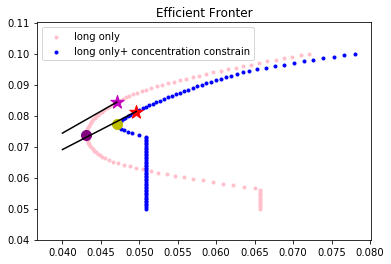

In [19]:

fronter_1= list( fronter1_vol.items())
fronter_1.sort( key=lambda x: x[1])
minvar_portf1= fronter_1[0]
minvar_portf1_w= fronter1_w[minvar_portf1[0]]
fronter_1.sort( key= lambda x: (x[0]- rf)/ x[1], reverse=True)
efficient_portf1= fronter_1[0]
efficient_portf1_w= fronter1_w[efficient_portf1[0]]

fronter_2= list(fronter2_vol.items())
fronter_2.sort(key= lambda x: x[1])
minvar_portf2= fronter_2[0]
minvar_portf2_w= fronter2_w[minvar_portf2[0]]
fronter_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2= fronter_2[0]
efficient_portf2_w= fronter2_w[efficient_portf2[0]]

[tmp_ret, tmp_vol]= zip( * list( fronter1_vol.items())) 
fig= plt.figure( )
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'pink' , label= 'long only')
plt.scatter(x= minvar_portf1[1], y= minvar_portf1[0], marker= 'o', c='purple', s= 100 )
plt.scatter(x= efficient_portf1[1], y = efficient_portf1[0], marker= '*', c='m', s=200)
plt.plot( [0.04, efficient_portf1[1]], [ (efficient_portf1[0]-rf)/efficient_portf1[1]* 0.04+rf, efficient_portf1[0]], 'k-')

[tmp_ret, tmp_vol]= zip(* list(fronter2_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='blue', label= 'long only+ concentration constrain')
plt.scatter( x= minvar_portf2[1], y=minvar_portf2[0], marker= 'o', c= 'y', s=100)
plt.scatter(x= efficient_portf2[1], y = efficient_portf2[0], marker= '*', c='r', s=200)
plt.plot( [0.04, efficient_portf2[1]], [ (efficient_portf2[0]-rf)/efficient_portf2[1]* 0.04+rf, efficient_portf2[0]], 'k-')
plt.legend()
plt.title('Efficient Fronter')

print(efficient_portf1)
print(efficient_portf1_w)
print(efficient_portf2)
print(efficient_portf2_w)

weight_longonly= efficient_portf1_w
weight_longonly_conc= efficient_portf2_w

In [20]:
portf_weight_2= pd.DataFrame([efficient_portf1_w, efficient_portf2_w], 
                             index=['CMA_weight_longonly', 'CMA_weight_longonly_conc'], columns=LW_cov.columns)
pd.concat([portf_weight_1, portf_weight_2], axis=0)

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,1.428571e-01,1.428571e-01,0.142857,0.142857
weight_peer,0.138614,0.287129,0.049505,2.376238e-01,2.970297e-02,0.207921,0.049505
weight_erc,0.282415,0.142979,0.177851,1.187341e-01,9.272408e-02,0.105874,0.079423
CMA_weight_longonly,0.576959,0.392526,0.015887,3.552456e-18,0.000000e+00,0.000000,0.014629
CMA_weight_longonly_conc,0.300000,0.300000,0.178279,1.696141e-01,3.210163e-17,0.029330,0.022777


In [21]:
## risk adj return optimal long only portfolio with CMA expected ret


def obj_func_CMA(w, ARGS):  # ARGS= [sigma, ExpRet, gamma]
    return (np.dot(  np.dot( w, ARGS[0]), w)* .5* ARGS[2]- np.dot( ARGS[1], w))

def obj_func_derivative_CMA( w, ARGS): 
    return (np.dot( w, ARGS[0])* ARGS[2]- ARGS[1])


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}


CMA_riskAdj_opt={}

for g in [2,2.5,3,3.5,4]: 

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          )

    MV_opt= minimize( obj_func_CMA, 
                    x0= weight_eq, 
                    args= [LW_cov, CMA_ExpRet_arith, g], 
                    jac= obj_func_derivative_CMA ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)
    
    CMA_riskAdj_opt[g]= MV_opt.x
    
CMA_riskAdj_portf_w= pd.DataFrame( CMA_riskAdj_opt, index=LW_cov.columns).T
CMA_riskAdj_portf_w.index= ['weight_CMA_MVO_gamma_'+str(x) for x in CMA_riskAdj_portf_w.index]
    


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019479826007340877
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.018450266469870222
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01747522085701578
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.016576791911206225
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01573940249981361
            Iterations: 23
      

In [22]:
CMA_riskAdj_portf_w

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_CMA_MVO_gamma_2.0,0.3,0.3,0.000000e+00,0.000000,0.180607,0.000000e+00,0.219393
weight_CMA_MVO_gamma_2.5,0.3,0.3,9.140117e-17,0.000000,0.216500,3.856257e-17,0.183500
weight_CMA_MVO_gamma_3.0,0.3,0.3,0.000000e+00,0.075994,0.161141,1.837060e-02,0.144495
weight_CMA_MVO_gamma_3.5,0.3,0.3,6.898587e-17,0.140589,0.113584,3.005979e-02,0.115767
weight_CMA_MVO_gamma_4.0,0.3,0.3,3.582843e-02,0.162162,0.077544,3.237553e-02,0.092089


In [23]:
## Introducing active management
# Apply active management to Equity (SP500, Rusell2000, EAFE and EM), 
# assuming IR of 1/3 and active alpha 1% and hence tracking error 3%, both annualized 


LW_vol= np.sqrt(np.diag(LW_cov))
LW_corr= pd.DataFrame(np.dot(np.dot(np.diag(1/LW_vol), LW_cov), np.diag(1/LW_vol)), columns= LW_cov.columns, index=LW_cov.index)
LW_cov_active= pd.DataFrame(LW_cov+ np.diag( np.array([0, 0, 0.0009/4, 0.0009/4, 0.0009/4, 0.0009/4, 0.0009/4])),
                           index= LW_cov.index,
                           columns= LW_cov.columns)
LW_vol_active= np.sqrt(np.diag(LW_cov_active))

CMA_ExpRet_active_geo= CMA_ExpRet_geo+ np.array([0,0,0.0075/4, 0.01/4, 0.01/4, 0.01/4, 0.01/4])
CMA_ExpRet_active_arith= CMA_ExpRet_arith+ np.array( [0,0,0.0075/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4 ])

LW_corr_active= pd.DataFrame(np.dot(np.dot(np.diag(1/LW_vol_active), LW_cov_active), np.diag(1/LW_vol_active)), 
                            index= LW_cov_active.index,
                            columns= LW_cov_active.columns)


In [24]:
## Fronter Construction with active management



fronter1_active_w= {}
fronter1_active_vol= {}
fronter2_active_w= {}
fronter2_active_vol= {}

for target_ret in np.linspace(0.065, 0.1, 100 ): 
    cons_ineq4_active= {'type': 'eq', 
                'fun': lambda w: -np.dot(w, CMA_ExpRet_active_arith*4)+ target_ret,
                'jac': lambda w: -CMA_ExpRet_active_arith*4}

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          , cons_ineq4_active
          )

    MV_active_opt_2= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov_active, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0,0.25]]+[[0, 0.4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)  # long only+ concentration constrain

    MV_active_opt_1= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov_active, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0, None]]* N,
                    tol= 1e-12)  # long only constrain
    
    fronter1_active_w[target_ret]= MV_active_opt_1.x
    fronter1_active_vol[target_ret]= np.sqrt(MV_active_opt_1.fun*2) 
    
    fronter2_active_w[target_ret]= MV_active_opt_2.x
    fronter2_active_vol[target_ret]= np.sqrt(MV_active_opt_2.fun*2)
    
    
    


Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0013135738490619268
            Iterations: 101
            Function evaluations: 887
            Gradient evaluations: 97
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00203450400479991
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0013135738491830916
            Iterations: 30
            Function evaluations: 245
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0019270247034073812
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0013135738491836975
            Iterations: 34
            Function e

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0013135738491840327
            Iterations: 53
            Function evaluations: 363
            Gradient evaluations: 49
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001477586193204187
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.0013135738491804054
            Iterations: 77
            Function evaluations: 771
            Gradient evaluations: 73
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001405290090515434
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0013135738491045947
            Iterations: 101
            F

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0013135738491198243
            Iterations: 101
            Function evaluations: 1020
            Gradient evaluations: 99
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0009426614711767328
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0013135738491828611
            Iterations: 60
            Function evaluations: 455
            Gradient evaluations: 56
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.000939940228280191
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0013135738491821993
            Iterations: 78
            Fu

            Current function value: 0.0012404038396816404
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0011104304447761314
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012535666469616282
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0011233922560539874
            Iterations: 36
            Function evaluations: 36
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001267167279062318
            Iterations: 25
            Function evaluations: 25
            Gradient ev

            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001813474663153773
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001760437711289922
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0018418572529555095
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0017930435112311156
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Curre

(0.084343434343434345, 0.047081945661880828)
[  5.76958650e-01   3.92525584e-01   1.58869429e-02   3.55245618e-18
   0.00000000e+00   0.00000000e+00   1.46288226e-02]
(0.081313131313131309, 0.049596874650441922)
[  3.00000000e-01   3.00000000e-01   1.78278771e-01   1.69614120e-01
   3.21016288e-17   2.93300999e-02   2.27770094e-02]
(0.084090909090909091, 0.046344778310554724)
[  5.39163618e-01   3.12269699e-01   5.54793646e-02   5.79459741e-02
   1.00669866e-18   1.39161193e-02   2.12252243e-02]
(0.085151515151515159, 0.049807707027761085)
[  3.00000000e-01   3.00000000e-01   1.71646197e-01   1.70585862e-01
   9.28253620e-18   3.95984112e-02   1.81695300e-02]


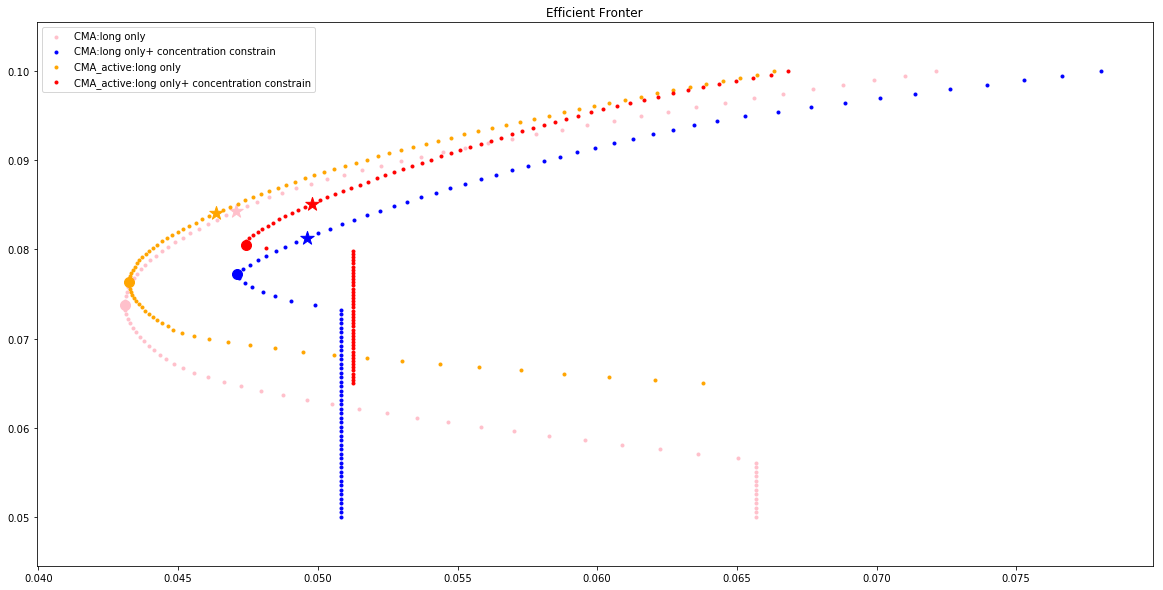

In [25]:

fronter_1= list( fronter1_vol.items())
fronter_1.sort( key=lambda x: x[1])
minvar_portf1= fronter_1[0]
minvar_portf1_w= fronter1_w[minvar_portf1[0]]
fronter_1.sort( key= lambda x: (x[0]- rf)/ x[1], reverse=True)
efficient_portf1= fronter_1[0]
efficient_portf1_w= fronter1_w[efficient_portf1[0]]

fronter_2= list(fronter2_vol.items())
fronter_2.sort(key= lambda x: x[1])
minvar_portf2= fronter_2[0]
minvar_portf2_w= fronter2_w[minvar_portf2[0]]
fronter_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2= fronter_2[0]
efficient_portf2_w= fronter2_w[efficient_portf2[0]]

fronter_active_1= list( fronter1_active_vol.items())
fronter_active_1.sort(key= lambda x: x[1])
minvar_active_portf1= fronter_active_1[0]
minvar_active_portf1_w= fronter1_active_w[minvar_active_portf1[0]]
fronter_active_1.sort(key= lambda x: (x[0]-rf)/x[1], reverse =True)
efficient_portf1_active= fronter_active_1[0]
efficient_portf1_active_w= fronter1_active_w[efficient_portf1_active[0]]


fronter_active_2= list( fronter2_active_vol.items())
fronter_active_2.sort( key= lambda x: x[1])
minvar_active_portf2= fronter_active_2[0]
minvar_active_portf2_w= fronter2_active_w[ minvar_active_portf2[0]]
fronter_active_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2_active= fronter_active_2[0]
efficient_portf2_active_w= fronter2_active_w[efficient_portf2_active[0]]


fig= plt.figure(figsize= (20,10))

[tmp_ret, tmp_vol]= zip( * list( fronter1_vol.items())) 
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'pink' , label= 'CMA:long only')
plt.scatter(x= minvar_portf1[1], y= minvar_portf1[0], marker= 'o', c='pink', s= 100 )
plt.scatter(x= efficient_portf1[1], y = efficient_portf1[0], marker= '*', c='pink', s=200)
# plt.plot( [0.04, efficient_portf1[1]], [ (efficient_portf1[0]-rf)/efficient_portf1[1]* 0.04+rf, efficient_portf1[0]], 
#          linestyle='-', c='pink')

[tmp_ret, tmp_vol]= zip(* list(fronter2_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='blue', label= 'CMA:long only+ concentration constrain')
plt.scatter( x= minvar_portf2[1], y=minvar_portf2[0], marker= 'o', c= 'blue', s=100)
plt.scatter(x= efficient_portf2[1], y = efficient_portf2[0], marker= '*', c='blue', s=200)
# plt.plot( [0.04, efficient_portf2[1]], [ (efficient_portf2[0]-rf)/efficient_portf2[1]* 0.04+rf, efficient_portf2[0]], 
#          linestyle= '-', c= 'blue')


[tmp_ret, tmp_vol]= zip( * list( fronter1_active_vol.items())) 
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'orange' , label= 'CMA_active:long only')
plt.scatter(x= minvar_active_portf1[1], y= minvar_active_portf1[0], marker= 'o', c='orange', s= 100 )
plt.scatter(x= efficient_portf1_active[1], y = efficient_portf1_active[0], marker= '*', c='orange', s=200)
# plt.plot( [0.04, efficient_portf1_active[1]], [ (efficient_portf1_active[0]-rf)/efficient_portf1_active[1]* 0.04+rf, efficient_portf1_active[0]], 
#          linestyle='-', c='orange')

[tmp_ret, tmp_vol]= zip(* list(fronter2_active_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='red', label= 'CMA_active:long only+ concentration constrain')
plt.scatter( x= minvar_active_portf2[1], y=minvar_active_portf2[0], marker= 'o', c= 'red', s=100)
plt.scatter(x= efficient_portf2_active[1], y = efficient_portf2_active[0], marker= '*', c='red', s=200)
# plt.plot( [0.04, efficient_portf2_active[1]], [ (efficient_portf2_active[0]-rf)/efficient_portf2_active[1]* 0.04+rf, efficient_portf2_active[0]], 
#          linestyle= '-', c='red')




plt.legend()
plt.title('Efficient Fronter')

print(efficient_portf1)
print(efficient_portf1_w)
print(efficient_portf2)
print(efficient_portf2_w)
print(efficient_portf1_active)
print(efficient_portf1_active_w)
print(efficient_portf2_active)
print(efficient_portf2_active_w)

weight_longonly= efficient_portf1_w
weight_longonly_conc= efficient_portf2_w

In [26]:
portf_weight_3= pd.DataFrame( [efficient_portf1_active_w, efficient_portf2_active_w],
                            index= ['CMA_active_weight_longonly', 'CMA_active_weight_longonly_conc'], 
                            columns= LW_cov.columns)

pd.concat([portf_weight_1, portf_weight_2, portf_weight_3], axis=0)

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,1.428571e-01,1.428571e-01,0.142857,0.142857
weight_peer,0.138614,0.287129,0.049505,2.376238e-01,2.970297e-02,0.207921,0.049505
weight_erc,0.282415,0.142979,0.177851,1.187341e-01,9.272408e-02,0.105874,0.079423
CMA_weight_longonly,0.576959,0.392526,0.015887,3.552456e-18,0.000000e+00,0.000000,0.014629
CMA_weight_longonly_conc,0.300000,0.300000,0.178279,1.696141e-01,3.210163e-17,0.029330,0.022777
CMA_active_weight_longonly,0.539164,0.312270,0.055479,5.794597e-02,1.006699e-18,0.013916,0.021225
CMA_active_weight_longonly_conc,0.300000,0.300000,0.171646,1.705859e-01,9.282536e-18,0.039598,0.018170


In [27]:
## Risk adj return utility constrained optimal with active management 




def obj_func_CMAactive(w, ARGS):  # ARGS= [sigma, ExpRet, gamma]
    return (np.dot(  np.dot( w, ARGS[0]), w)* .5* ARGS[2]- np.dot( ARGS[1], w))

def obj_func_derivative_CMAactive( w, ARGS): 
    return (np.dot( w, ARGS[0])* ARGS[2]- ARGS[1])


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}


CMAactive_riskAdj_opt={}
CMAactive_riskAdj_opt2={}
for g in [3,3.5,4]: 

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          )

    MV_opt= minimize( obj_func_CMAactive, 
                    x0= weight_eq, 
                    args= [LW_cov_active, CMA_ExpRet_active_arith, g], 
                    jac= obj_func_derivative_CMAactive ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)

    MV_opt2= minimize( obj_func_CMAactive, 
                    x0= weight_eq, 
                    args= [LW_cov_active, CMA_ExpRet_active_arith, g], 
                    jac= obj_func_derivative_CMAactive ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0,None]]* N,
                    tol= 1e-12)
    
    CMAactive_riskAdj_opt[g]= MV_opt.x
    CMAactive_riskAdj_opt2[g]= MV_opt2.x
    
CMAactive_riskAdj_portf_w= pd.DataFrame( CMAactive_riskAdj_opt, index=LW_cov_active.columns).T
CMAactive_riskAdj_portf_w.index= ['weight_CMAactive_MVO_gamma_'+str(x) for x in CMAactive_riskAdj_portf_w.index]
CMAactive_riskAdj_portf_w2= pd.DataFrame( CMAactive_riskAdj_opt2, index= LW_cov_active.columns).T
CMAactive_riskAdj_portf_w2.index= ['weight_CMAactive_MVO_gamma_'+str(x)+'uncons' for x in CMAactive_riskAdj_portf_w.index]
CMAactive_riskAdj_portf_w


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.018502647757496642
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.018673727872844652
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.017603590448697876
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.017893465271042158
            Iterations: 36
            Function evaluations: 37
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.016750084655004403
            Iterations: 32
    

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_CMAactive_MVO_gamma_3.0,0.3,0.3,0.000000,0.078008,0.155415,0.023572,0.143006
weight_CMAactive_MVO_gamma_3.5,0.3,0.3,0.000000,0.133980,0.114633,0.036827,0.114561
weight_CMAactive_MVO_gamma_4.0,0.3,0.3,0.010328,0.168906,0.083499,0.044666,0.092601


In [28]:
  #pd.DataFrame(CMAactive_riskAdj_opt[2],)

In [29]:
portf_weight= pd.concat( [portf_weight_1, 
                          portf_weight_2, 
                          CMA_riskAdj_portf_w.iloc[ -3:] ,
                          portf_weight_3, 
                          CMAactive_riskAdj_portf_w,
                         CMAactive_riskAdj_portf_w2], axis= 0 )
portf_weight.index= ['w_eq', # equal weight 
                    'w_peer', # peer weight
                    'w_erc', # equal risk contribution weight 
                    'w_MVO_1', # mean-variance optimal weight with long only constrain
                    'w_MVO_2', # mean-variance optimal weight with long only+ concentration constrain
                    'w_RUO_3', # risk adj utility optimal weight with long only+ concentration constrain, give risk aversion 3 
                    'w_RUO_3.5', # risk adj utility optimal weight with long only+ concentration constrain, given risk aversion 3.5
                    'w_RUO_4', # risk adj utility optimal weight with long only+ concentration constrain, give risk aversion 4
                    'w_aMVO_1', # mean-variance optimal weight with long only constrain, and active management 
                    'w_aMVO_2', # mean-variance optimal weight with long only+ concentration constrain, and active management 
                    'w_aRUO_3', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 3 
                    'w_aRUO_3.5', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 3.5 
                    'w_aRUO_4', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 4
                    'w_aRUO_3unc',
                    'w_aRUO_3.5unc',
                    'w_aRUO_4unc'] 
portf_weight

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
w_eq,0.142857,0.142857,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,0.142857
w_peer,0.138614,0.287129,4.950495e-02,2.376238e-01,2.970297e-02,2.079208e-01,0.049505
w_erc,0.282415,0.142979,1.778511e-01,1.187341e-01,9.272408e-02,1.058735e-01,0.079423
w_MVO_1,0.576959,0.392526,1.588694e-02,3.552456e-18,0.000000e+00,0.000000e+00,0.014629
w_MVO_2,0.300000,0.300000,1.782788e-01,1.696141e-01,3.210163e-17,2.933010e-02,0.022777
w_RUO_3,0.300000,0.300000,0.000000e+00,7.599354e-02,1.611408e-01,1.837060e-02,0.144495
w_RUO_3.5,0.300000,0.300000,6.898587e-17,1.405892e-01,1.135842e-01,3.005979e-02,0.115767
w_RUO_4,0.300000,0.300000,3.582843e-02,1.621623e-01,7.754428e-02,3.237553e-02,0.092089
w_aMVO_1,0.539164,0.312270,5.547936e-02,5.794597e-02,1.006699e-18,1.391612e-02,0.021225
w_aMVO_2,0.300000,0.300000,1.716462e-01,1.705859e-01,9.282536e-18,3.959841e-02,0.018170


In [30]:
ExpRet=  pd.concat([implied_ExpRet['weight_eq'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T, 
                   implied_ExpRet['weight_peer'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T,
                   implied_ExpRet['weight_erc'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T,
                   pd.DataFrame([CMA_ExpRet_geo,CMA_ExpRet_active_geo], columns= LW_cov.columns)], 
                   axis=0)* 400
ExpRet.index= ['iRet_eq_3', # implied expected return from equal weight with risk aversion 3
               'iRet_eq_3.5', # implied expected return from equal weight with risk aversion 3.5
               'iRet_eq_4',
               'iRet_peer_3', # implied expected return from peer weight with risk aversion 3
               'iRet_peer_3.5', # implied expected return from peer weight with risk aversion 3.5
               'iRet_peer_4',
               'iRet_erc_3', # implied expected return from equal risk contribution weight with risk aversion 3
               'iRet_erc_3.5',# implied expected return from equal risk contribution weight with risk aversion 3.5
               'iRet_erc_4',
               'CMA', # CMA expected return 
               'CMA_active' # CMA expected return, and active management
              ]

ExpRet # annualized expected ret in percentage 

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.946497,5.112730,4.197299,5.940288,6.745272,6.198200,6.975123
iRet_eq_3.5,3.223899,5.834154,4.742391,6.827058,7.894844,7.209535,8.370075
iRet_eq_4,3.501302,6.555578,5.287484,7.713828,9.044416,8.220869,9.765026
iRet_peer_3,2.875835,5.296642,3.655122,5.827752,6.117100,6.102522,5.785744
iRet_peer_3.5,3.141460,6.048718,4.109852,6.695766,7.161977,7.097910,6.982466
iRet_peer_4,3.407086,6.800794,4.564582,7.563779,8.206854,8.093298,8.179187
iRet_erc_3,3.116898,4.408355,3.840304,4.983875,5.436244,5.024522,5.129680
iRet_erc_3.5,3.422701,5.012383,4.325897,5.711243,6.367644,5.840244,6.217058
iRet_erc_4,3.728504,5.616411,4.811491,6.438610,7.299045,6.655965,7.304435
CMA,7.000000,8.800000,4.770000,7.210000,8.060000,7.070000,8.030000


### Black-Litterman Framework 

Construct BL framework to incorporate benchmark(prior) and views(observations) and produce a reasonable distribution of expected return (posterior). 
Apply mean-variance optimization based on posterior to achieve optimal allocation. 

#### Benckmark/Equilibrium Portfolio

Set the benchmark as peer holding `w_peer`, then `iRet_peer_3.5` is the implied equilibrium\benchmark expected return, given risk aversion factor 3.5.

#### The prior confidence  $\tau$

Follow BL's initial setting, $\tau = 0.05$

#### Views

`CMA_active` is the subjective view to expected return of each asset. The confidence is proportional to view portfolio (prior) variance with multiplier $\tau$





#### As summary, input: 

$\tau$

prior expected ret distribution, assuming normal, so the prior mean and variance 

views, the view portfolio weight, asserted expected ret, and view confidence. 

#### output: 

the posterior distribution, mean and variance of post expected return. 

In [31]:

## prepare input

tau = 5e-2
prior_cov= LW_cov* tau
prior_cov_inv= np.linalg.inv(prior_cov)
prior_mean= np.array(ExpRet.loc['iRet_peer_3.5'].tolist())/100/4+ 0.5* np.diag(LW_cov)



# CMA_ExpRet_active_arith 
# is the asserted expected return 
view_w= np.identity(N)
view_ExpRet= CMA_ExpRet_active_arith
view_cov= ( (LW_cov_active)* tau * 2)
view_cov_inv= np.linalg.inv( view_cov)

##  output: post 

A= prior_cov_inv
B= np.dot( np.dot(view_w.T, view_cov_inv), view_w)
C= np.dot(prior_cov_inv, prior_mean)
D= np.dot(np.dot(view_w.T, view_cov_inv), view_ExpRet)

post_mean_arith= pd.DataFrame( np.dot(np.linalg.inv( A+B), C+D), index=LW_cov.index, columns= ['post_ExpRet']) .T
post_cov= pd.DataFrame( np.linalg.inv( prior_cov_inv+ np.dot( np.dot( view_w.T, view_cov_inv), view_w)), index= LW_cov.index, columns= LW_cov.columns)
post_mean_geo= post_mean_arith- .5* np.diag( LW_cov_active)

In [32]:
pd.concat([ ExpRet.loc[['iRet_peer_3.5', 'CMA_active']], 
          post_mean_geo*400], axis=0)


,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_peer_3.5,3.14146,6.048718,4.109852,6.695766,7.161977,7.09791,6.982466
CMA_active,7.00000,8.800000,5.520000,8.210000,9.060000,8.07000,9.030000
post_ExpRet,4.42764,6.965812,4.543940,7.173288,7.772621,7.40399,7.634548


In [33]:
post_cov

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,0.000085,0.000035,0.000027,0.000039,0.000051,0.000039,0.000049
US_PE,0.000035,0.000168,0.000059,0.000124,0.000156,0.000130,0.000171
US_HY,0.000027,0.000059,0.000146,0.000083,0.000106,0.000091,0.000127
SP500,0.000039,0.000124,0.000083,0.000197,0.000209,0.000177,0.000207
Rusell2000,0.000051,0.000156,0.000106,0.000209,0.000326,0.000209,0.000286
EAFE,0.000039,0.000130,0.000091,0.000177,0.000209,0.000279,0.000257
EM,0.000049,0.000171,0.000127,0.000207,0.000286,0.000257,0.000533


In [34]:
## MVO based over post expected mean and variance


MV_opt= minimize( obj_func_CMA, 
                x0= weight_eq, 
                args= [LW_cov_active+ post_cov, post_mean_arith, 4], 
                jac= obj_func_derivative_CMA ,
                method= 'SLSQP',
                options= {'disp': True},
                constraints= cons, 
                #bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                bounds= [[0,0.3]]* (N),
                tol= 1e-120)

MV_opt.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.012175617663712581
            Iterations: 36
            Function evaluations: 38
            Gradient evaluations: 36


array([ 0.3       ,  0.3       ,  0.0250876 ,  0.15948793,  0.03391084,
        0.12635039,  0.05516323])

In [35]:
MV_unc_opt= minimize( obj_func_CMA, 
                x0= weight_eq, 
                args= [LW_cov_active+ post_cov, post_mean_arith, 4], 
                jac= obj_func_derivative_CMA ,
                method= 'SLSQP',
                options= {'disp': True},
                constraints= cons, 
                bounds= [[0,None]]* N,
                tol= 1e-120)

MV_unc_opt.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.012180486978360865
            Iterations: 44
            Function evaluations: 55
            Gradient evaluations: 44


C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


array([ 0.30986589,  0.32137822,  0.01415427,  0.14598856,  0.03094773,
        0.12262675,  0.05503858])

In [36]:
portf_weight_final= pd.concat( [portf_weight,
                         pd.DataFrame( [MV_opt.x, MV_unc_opt.x], columns= portf_weight.columns, index= ['w_BL', 'w_BL_unc'])], axis=0)
portf_weight_final

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
w_eq,0.142857,0.142857,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,0.142857
w_peer,0.138614,0.287129,4.950495e-02,2.376238e-01,2.970297e-02,2.079208e-01,0.049505
w_erc,0.282415,0.142979,1.778511e-01,1.187341e-01,9.272408e-02,1.058735e-01,0.079423
w_MVO_1,0.576959,0.392526,1.588694e-02,3.552456e-18,0.000000e+00,0.000000e+00,0.014629
w_MVO_2,0.300000,0.300000,1.782788e-01,1.696141e-01,3.210163e-17,2.933010e-02,0.022777
w_RUO_3,0.300000,0.300000,0.000000e+00,7.599354e-02,1.611408e-01,1.837060e-02,0.144495
w_RUO_3.5,0.300000,0.300000,6.898587e-17,1.405892e-01,1.135842e-01,3.005979e-02,0.115767
w_RUO_4,0.300000,0.300000,3.582843e-02,1.621623e-01,7.754428e-02,3.237553e-02,0.092089
w_aMVO_1,0.539164,0.312270,5.547936e-02,5.794597e-02,1.006699e-18,1.391612e-02,0.021225
w_aMVO_2,0.300000,0.300000,1.716462e-01,1.705859e-01,9.282536e-18,3.959841e-02,0.018170


In [37]:
portf_weight_final.loc[['w_peer', 'w_aRUO_3.5', 'w_BL', 'w_BL_unc']]

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
w_peer,0.138614,0.287129,0.049505,0.237624,0.029703,0.207921,0.049505
w_aRUO_3.5,0.300000,0.300000,0.000000,0.133980,0.114633,0.036827,0.114561
w_BL,0.300000,0.300000,0.025088,0.159488,0.033911,0.126350,0.055163
w_BL_unc,0.309866,0.321378,0.014154,0.145989,0.030948,0.122627,0.055039


In [38]:
ExpRet_final= pd.concat([ExpRet, 
                        post_mean_geo*400], axis=0)
ExpRet_final

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.946497,5.112730,4.197299,5.940288,6.745272,6.198200,6.975123
iRet_eq_3.5,3.223899,5.834154,4.742391,6.827058,7.894844,7.209535,8.370075
iRet_eq_4,3.501302,6.555578,5.287484,7.713828,9.044416,8.220869,9.765026
iRet_peer_3,2.875835,5.296642,3.655122,5.827752,6.117100,6.102522,5.785744
iRet_peer_3.5,3.141460,6.048718,4.109852,6.695766,7.161977,7.097910,6.982466
iRet_peer_4,3.407086,6.800794,4.564582,7.563779,8.206854,8.093298,8.179187
iRet_erc_3,3.116898,4.408355,3.840304,4.983875,5.436244,5.024522,5.129680
iRet_erc_3.5,3.422701,5.012383,4.325897,5.711243,6.367644,5.840244,6.217058
iRet_erc_4,3.728504,5.616411,4.811491,6.438610,7.299045,6.655965,7.304435
CMA,7.000000,8.800000,4.770000,7.210000,8.060000,7.070000,8.030000


In [39]:
pd.DataFrame(np.sqrt(np.diag( LW_cov))).T*2

,0,1,2,3,4,5,6
0,0.100789,0.141832,0.131397,0.152992,0.197087,0.182198,0.252372


In [40]:
LW_corr

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.290357,0.243449,0.301545,0.307428,0.255969,0.229836
US_PE,0.290357,1.000000,0.377413,0.682977,0.671396,0.604658,0.572320
US_HY,0.243449,0.377413,1.000000,0.497447,0.488964,0.455539,0.459033
SP500,0.301545,0.682977,0.497447,1.000000,0.832526,0.763682,0.644399
Rusell2000,0.307428,0.671396,0.488964,0.832526,1.000000,0.698464,0.691124
EAFE,0.255969,0.604658,0.455539,0.763682,0.698464,1.000000,0.669628
EM,0.229836,0.572320,0.459033,0.644399,0.691124,0.669628,1.000000


In [41]:
LW_corr_active

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.290357,0.237342,0.295909,0.303927,0.252569,0.228229
US_PE,0.290357,1.000000,0.367945,0.670214,0.663750,0.596624,0.568319
US_HY,0.237342,0.367945,1.000000,0.475904,0.471268,0.438210,0.444389
SP500,0.295909,0.670214,0.475904,1.000000,0.807664,0.739453,0.627936
Rusell2000,0.303927,0.663750,0.471268,0.807664,1.000000,0.681336,0.678477
EAFE,0.252569,0.596624,0.438210,0.739453,0.681336,1.000000,0.656112
EM,0.228229,0.568319,0.444389,0.627936,0.678477,0.656112,1.000000


In [42]:
pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(portf_weight.iloc[0:3], LW_cov), portf_weight.iloc[0:3].T)))*2).T

,0,1,2
0,0.130784,0.124802,0.109958


In [43]:
ExpRet_final

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.946497,5.112730,4.197299,5.940288,6.745272,6.198200,6.975123
iRet_eq_3.5,3.223899,5.834154,4.742391,6.827058,7.894844,7.209535,8.370075
iRet_eq_4,3.501302,6.555578,5.287484,7.713828,9.044416,8.220869,9.765026
iRet_peer_3,2.875835,5.296642,3.655122,5.827752,6.117100,6.102522,5.785744
iRet_peer_3.5,3.141460,6.048718,4.109852,6.695766,7.161977,7.097910,6.982466
iRet_peer_4,3.407086,6.800794,4.564582,7.563779,8.206854,8.093298,8.179187
iRet_erc_3,3.116898,4.408355,3.840304,4.983875,5.436244,5.024522,5.129680
iRet_erc_3.5,3.422701,5.012383,4.325897,5.711243,6.367644,5.840244,6.217058
iRet_erc_4,3.728504,5.616411,4.811491,6.438610,7.299045,6.655965,7.304435
CMA,7.000000,8.800000,4.770000,7.210000,8.060000,7.070000,8.030000


In [44]:
pd.DataFrame(np.dot(LW_cov, portf_weight.loc[['w_eq', 'w_peer', 'w_erc']].T), index=LW_cov.index, columns= ['ew', 'peer', 'erc'])*4

,ew,peer,erc
US_RE,0.005548,0.005313,0.006116
US_PE,0.014428,0.015042,0.012081
US_HY,0.010902,0.009095,0.009712
SP500,0.017735,0.017360,0.014547
Rusell2000,0.022991,0.020898,0.018628
EAFE,0.020227,0.019908,0.016314
EM,0.027899,0.023934,0.021748


In [45]:
tmp_w= portf_weight_final.loc[[ 'w_aRUO_3.5unc', 'w_aRUO_3.5']]

tmp_ret= np.dot(tmp_w, ExpRet_final.loc['CMA_active'])/100
tmp_vol= np.sqrt(np.diag(np.dot(np.dot(tmp_w, LW_cov_active), tmp_w.T)))*2

pd.DataFrame(tmp_ret).T

,0,1
0,0.081116,0.082102


In [46]:
pd.DataFrame(tmp_vol).T

,0,1
0,0.109126,0.118232


In [47]:
pd.DataFrame(view_w)

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
pd.DataFrame(ExpRet_final.loc['CMA_active'])

,CMA_active
US_RE,7.00
US_PE,8.80
US_HY,5.52
SP500,8.21
Rusell2000,9.06
EAFE,8.07
EM,9.03


In [49]:
bl_w= portf_weight_final.loc[['w_BL_unc', 'w_BL']]
bl_ret= ExpRet_final.loc['post_ExpRet'].values/100
bl_w.T

,w_BL_unc,w_BL
US_RE,0.309866,0.300000
US_PE,0.321378,0.300000
US_HY,0.014154,0.025088
SP500,0.145989,0.159488
Rusell2000,0.030948,0.033911
EAFE,0.122627,0.126350
EM,0.055039,0.055163


In [50]:
tmp_ret_BL=pd.DataFrame(np.dot(bl_w, bl_ret)).T
tmp_vol_BL= pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(bl_w, LW_cov_active+ post_cov), bl_w.T)))*2).T

pd.concat( [tmp_ret_BL, tmp_vol_BL], axis=0)

,0,1
0,0.062908,0.062963
0,0.112647,0.113087


In [51]:
LW_cov_active

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,0.002540,0.001038,0.000806,0.001162,0.001527,0.001175,0.001462
US_PE,0.001038,0.005029,0.001758,0.003705,0.004692,0.003906,0.005121
US_HY,0.000806,0.001758,0.004541,0.002500,0.003166,0.002726,0.003805
SP500,0.001162,0.003705,0.002500,0.006077,0.006276,0.005322,0.006220
Rusell2000,0.001527,0.004692,0.003166,0.006276,0.009936,0.006270,0.008594
EAFE,0.001175,0.003906,0.002726,0.005322,0.006270,0.008524,0.007698
EM,0.001462,0.005121,0.003805,0.006220,0.008594,0.007698,0.016148


In [52]:
LW_cov_active+ post_cov

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,0.002624,0.001072,0.000833,0.001201,0.001578,0.001214,0.001510
US_PE,0.001072,0.005197,0.001817,0.003829,0.004848,0.004037,0.005292
US_HY,0.000833,0.001817,0.004688,0.002583,0.003271,0.002817,0.003932
SP500,0.001201,0.003829,0.002583,0.006274,0.006485,0.005499,0.006428
Rusell2000,0.001578,0.004848,0.003271,0.006485,0.010262,0.006479,0.008880
EAFE,0.001214,0.004037,0.002817,0.005499,0.006479,0.008803,0.007954
EM,0.001510,0.005292,0.003932,0.006428,0.008880,0.007954,0.016681


In [53]:

tmp_w= portf_weight_final.loc[[ 'w_aRUO_3.5', 'w_aRUO_3.5']]

tmp_ret= np.dot(tmp_w, ExpRet_final.loc['CMA_active'])/100


tmp_vol= pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(tmp_w, LW_cov_active), tmp_w.T)))*2).T

pd.DataFrame(tmp_ret).T



,0,1
0,0.082102,0.082102


In [54]:
pd.DataFrame(tmp_vol).T

,0
0,0.118232
1,0.118232


### Bechmark+ active 

Benchmark = Peer

Active= Max (risk adj return) with const dollar neutral 


What is the corr of Benchmark and Active? 

How to combine to max SR? with const that final portfolio is long only. 



In [88]:
benchmark_w= portf_weight_final.loc['w_peer'].tolist()
benchmark_w

[0.13861386138613863,
 0.2871287128712871,
 0.04950495049504951,
 0.2376237623762376,
 0.0297029702970297,
 0.2079207920792079,
 0.04950495049504951]

In [60]:
# ExpRet_final

In [67]:
CMA_ExpRet_active_arith

array([ 0.0187698 ,  0.02451454,  0.01607064,  0.02356332,  0.0276179 ,
        0.02443702,  0.03064896])

In [58]:
LW_cov_active

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,0.002540,0.001038,0.000806,0.001162,0.001527,0.001175,0.001462
US_PE,0.001038,0.005029,0.001758,0.003705,0.004692,0.003906,0.005121
US_HY,0.000806,0.001758,0.004541,0.002500,0.003166,0.002726,0.003805
SP500,0.001162,0.003705,0.002500,0.006077,0.006276,0.005322,0.006220
Rusell2000,0.001527,0.004692,0.003166,0.006276,0.009936,0.006270,0.008594
EAFE,0.001175,0.003906,0.002726,0.005322,0.006270,0.008524,0.007698
EM,0.001462,0.005121,0.003805,0.006220,0.008594,0.007698,0.016148


In [76]:
## active 


cons_dollarNeutral= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)] ) ,
          'jac': lambda w: np.array( [1]*N)}

cons= (cons_dollarNeutral)
MV_active_opt= minimize( obj_func_CMA, 
                x0= weight_eq, 
                args= [LW_cov_active, CMA_ExpRet_active_arith*4, 3.5], 
                jac= obj_func_derivative_CMA ,
                method= 'SLSQP',
                options= {'disp': True},
                constraints= cons, 
                bounds= [[None,None]]* N,
                tol= 1e-120)

active_w= MV_active_opt.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.04975089682802483
            Iterations: 39
            Function evaluations: 56
            Gradient evaluations: 39


C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


In [93]:
active_vol= np.sqrt( np.dot( np.dot( active_w, LW_cov_active), active_w)) *2
actuve_ExpRet= np.dot( active_w, CMA_ExpRet_active_geo*4)

In [94]:
active_vol

0.33721852789112011

In [95]:
actuve_ExpRet

0.071617352936821435

In [96]:
benchmark_w

[0.13861386138613863,
 0.2871287128712871,
 0.04950495049504951,
 0.2376237623762376,
 0.0297029702970297,
 0.2079207920792079,
 0.04950495049504951]

In [97]:
benchmark_vol= np.sqrt(np.dot( np.dot(benchmark_w, LW_cov_active), benchmark_w))*2

In [99]:

benchmark_ExpRet= np.dot(benchmark_w, CMA_ExpRet_active_geo*4)

In [100]:
benchmark_ExpRet

0.081152475247524752

In [102]:
# correlation

ba_corr= np.dot( np.dot(benchmark_w, LW_cov_active), active_w)/ (benchmark_vol/2 * active_vol /2)

In [105]:
def SR_ba( lam):
    return (benchmark_ExpRet+ lam* actuve_ExpRet)/ np.sqrt( benchmark_vol**2+ lam**2 *  active_vol**2+ 2*lam* benchmark_vol * active_vol* ba_corr)

[]

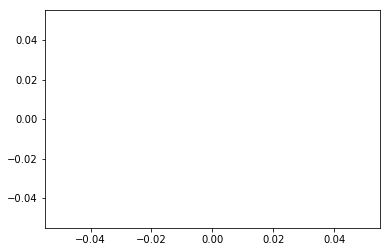

In [107]:
plt.plot(x= np.linspace(0,1,100), y=  SR_ba(np.linspace(0,1,100)))

In [109]:
SR_ba(np.linspace(0,1, 100))

array([ 0.64827779,  0.64374515,  0.63906297,  0.63425792,  0.62935445,
        0.6243748 ,  0.61933912,  0.61426559,  0.60917048,  0.60406833,
        0.59897201,  0.5938929 ,  0.588841  ,  0.583825  ,  0.57885247,
        0.57392992,  0.5690629 ,  0.56425613,  0.55951352,  0.55483835,
        0.55023325,  0.54570032,  0.54124118,  0.53685702,  0.53254865,
        0.52831657,  0.52416096,  0.52008179,  0.51607877,  0.51215146,
        0.50829923,  0.50452133,  0.50081687,  0.49718489,  0.49362432,
        0.49013404,  0.48671287,  0.48335958,  0.48007293,  0.47685161,
        0.47369434,  0.47059979,  0.46756666,  0.46459362,  0.46167937,
        0.45882259,  0.45602199,  0.4532763 ,  0.45058424,  0.44794457,
        0.44535606,  0.44281752,  0.44032775,  0.43788559,  0.43548991,
        0.4331396 ,  0.43083356,  0.42857073,  0.42635007,  0.42417057,
        0.42203123,  0.4199311 ,  0.41786922,  0.41584468,  0.41385658,
        0.41190405,  0.40998625,  0.40810234,  0.40625152,  0.40